#### Welcome, This Project was developed by Akshat Khare an Engineering Undergraduate student pursuing Computer Science from SRMIST(SRM INSTITUTE OF SCIENCE AND TECHNOLOGY), 2023. The aim of this project is to develop an Artificial Intelligence specifically Computer Vision Powered program which could be installed in CCTV cameras in highways to record number of INGOING and OUTGOING Traffic which could help determine usage of that particular road, street or highway. 

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import pydot
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

# Preparing CIFAR10 Dataset for the models as CIFAR10 contains almost land vehicles data.
(X_train , Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

### Model Implementation

In [42]:
class Model:
    def __init__(self, base_model, shape, name):
        self.shape = shape
        self.name = name
        self.model = 0
        if (base_model != None):
            self.model_input = tf.keras.layers.Input(shape = self.shape)
            self.base_model = base_model(weights = "imagenet", include_top = False, input_tensor = self.model_input)
            self.constraint_layer_training = len(self.base_model.layers) // 2
            for layer in self.base_model.layers[:self.constraint_layer_training]:
                layer.trainable = False
            for layer in self.base_model.layers[self.constraint_layer_training:]:
                layer.trainable = True
            

    def build_model(self):
        x = tf.keras.layers.Conv2D(32, (3,3), padding='same',activation = "elu", kernel_initializer = 'lecun_normal')(self.model_input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(32, (3,3), padding='same',activation = "elu", kernel_initializer='lecun_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Conv2D(64, (3,3), padding='same',activation = "elu",kernel_initializer='lecun_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(64, (3,3), padding='same',activation = "elu",kernel_initializer='lecun_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        x = tf.keras.layers.Conv2D(128, (3,3), padding='same',activation = "elu",kernel_initializer='lecun_normal' )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(128, (3,3), padding='same',activation = "elu",kernel_initializer='lecun_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        flatten = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(512, activation ="relu", kernel_initializer =  "he_normal")(flatten)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(256, activation = "relu" , kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation = "relu" , kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(64, activation = "relu" , kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(32, activation = "relu" , kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        output = tf.keras.layers.Dense(10, activation="softmax", name = "output")(x)

        self.model = tf.keras.models.Model(inputs = self.model_input, outputs = output, name = self.name)
        print(self.model.summary())
    
    def plot_loss_acc(self):
        #Loss vs Epochs
        plt.plot(self.model.history.history['loss'], label='train')
        plt.plot(self.model.history.history['val_loss'], label='test')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Loss vs Epochs")
        plt.legend()
        plt.show()
        #Accuracy vs Epochs
        plt.plot(self.model.history.history['accuracy'], label='train')
        plt.plot(self.model.history.history['val_accuracy'], label='test')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"{self.name} ACCURACY vs Epochs")
        plt.legend()
        plt.show()
        
    def scoring(self):
        y_test_0 = [np.argmax(i) for i in Y_test]
        y_pred_0 = [np.argmax(i) for i in self.model.predict(X_test)]
        cm = confusion_matrix(y_test_0, y_pred_0)
        print(classification_report(y_test_0,y_pred_0))
        df_cm = pd.DataFrame(cm)
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        
    def compile_and_train(self, train_gen, lr = 1e-3, epochs = 50):
        #earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        #checkpoint_cb = callbacks.ModelCheckpoint(f"Models/{self.model.name}.h5", save_best_only = True)
        self.model.compile(loss="categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
        self.model.fit(X_train, Y_train, epochs = epochs, validation_data = (X_test, Y_test), workers = -1)#,callbacks = [checkpoint_cb])#, earlystopping_cb])
        self.plot_loss_acc()
        self.scoring()

### Model compilation and training

Model: "DenseNet169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        

1563/1563 [==============================] - 37s 23ms/step - loss: 0.3869 - accuracy: 0.8664 - val_loss: 0.4756 - val_accuracy: 0.8389
Epoch 14/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.3632 - accuracy: 0.8756 - val_loss: 0.4642 - val_accuracy: 0.8462
Epoch 15/50
1563/1563 [==============================] - 25s 16ms/step - loss: 0.3482 - accuracy: 0.8796 - val_loss: 0.4790 - val_accuracy: 0.8445
Epoch 16/50
1563/1563 [==============================] - 25s 16ms/step - loss: 0.3321 - accuracy: 0.8853 - val_loss: 0.4627 - val_accuracy: 0.8504
Epoch 17/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.3120 - accuracy: 0.8906 - val_loss: 0.4846 - val_accuracy: 0.8434
Epoch 18/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.2919 - accuracy: 0.8989 - val_loss: 0.4635 - val_accuracy: 0.8488
Epoch 19/50
1563/1563 [==============================] - 26s 17ms/step - loss: 0.2817 - accuracy: 0.9016 - val_loss: 0.4457 - val_

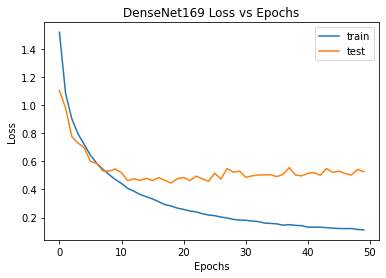

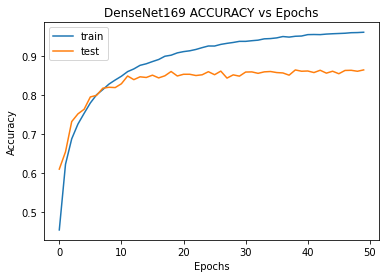

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1000
           1       0.93      0.94      0.93      1000
           2       0.85      0.78      0.81      1000
           3       0.76      0.71      0.74      1000
           4       0.85      0.86      0.85      1000
           5       0.79      0.81      0.80      1000
         

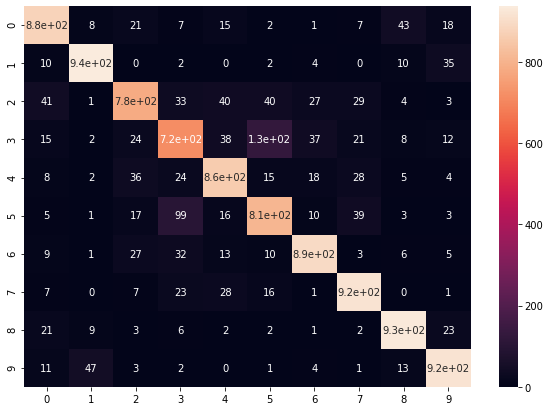

In [43]:
#datagen = ImageDataGenerator(
#        width_shift_range=0.2,
#        height_shift_range=0.2,
#        shear_range=0.2,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        fill_mode='nearest')
#
#datagen.fit(X_train)

model = Model(tf.keras.applications.densenet.DenseNet169, (32, 32, 3), "DenseNet169")
model.build_model()
model.compile_and_train(None)
model.model.save("Models/model.h5")

In [44]:
model.model.evaluate(X_test, Y_test, batch_size=128)
#model.model = tf.keras.models.load_model("Models/model.h5")

79/79 [==============================] - 1s 16ms/step - loss: 0.5258 - accuracy: 0.8639


[0.5258020162582397, 0.8639000058174133]

In [20]:
import cv2
import numpy as np

cap = cv2.VideoCapture("D:/Python Projects/Data/Videos/carstest.mp4")

ret, frame1 = cap.read()
width  = cap.get(3)  # float `width`
height = cap.get(4)  # float `height`
i = 0
while cap.isOpened():
    ret, frame2 = cap.read()
    diff = cv2.absdiff(frame1, frame2)
    diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(diff, (3, 3), 0)
    _, thresh = cv2.threshold(blur, 30, 255, cv2.THRESH_BINARY)
    dilate = cv2.dilate(thresh, None, iterations = 1)
    contours, _ = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if cv2.contourArea(contour) < 1000:
            continue
        (x, y, w, h) = cv2.boundingRect(contour)
        image_frame = np.zeros((int(width), int(height), 3), np.float32)
        image_frame = frame1[y : y + h, x : x + w]
        image_frame = cv2.resize(image_frame, (32, 32))
        image_frame = np.reshape(image_frame, (1, 32, 32, 3))
        image_frame= image_frame.astype(np.float32)
        
        prediction = np.argmax(model.model.predict(image_frame / 255.0))
        if(prediction == 1):
            cv2.putText(frame1, "Car", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.rectangle(frame1, (x, y), (x + w, y + h), (0, 255, 0), 2, cv2.LINE_AA)
        elif(prediction == 9):
            cv2.putText(frame1, "Truck", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.rectangle(frame1, (x, y), (x + w, y + h), (0, 255, 0), 2, cv2.LINE_AA)
        
        cv2.putText(frame1, "Status : Movement", (10, 20), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
    cv2.imshow("Frame", frame1)    
    frame1 = frame2
    if cv2.waitKey(40) == 27:
        break
    i += 1
    
cv2.destroyAllWindows()
cap.release()

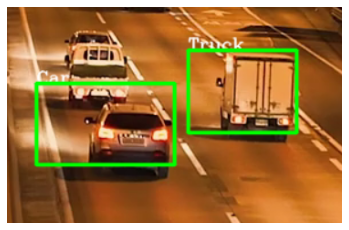

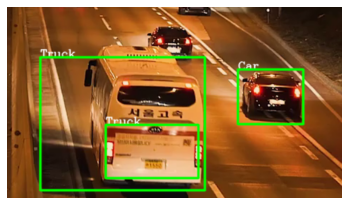

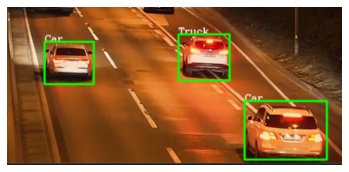

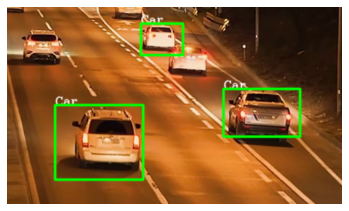

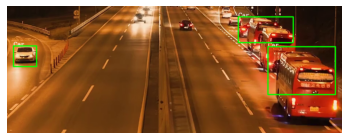

In [29]:
import glob
for i in glob.glob("Predicted_Images/*"):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB))
    plt.show()

### Challenges Faced 
#### Dataset used did not quite provide VARIETY and VERSATILITY in terms of images. Model's performance depends upon the diversity and variability of the dataset which clearly could not be achieved using CIFAR10 which has only 50000 images and that to with small size i.e. (32, 32, 3) which impacted on performance of model's feature extraction. Model hyperparameters were not optimized to provide efficient performance.
### Achievements
#### Results are very clear, and can be used as a program installed in CCTV cameras to record the numbers of outgoing and incoming vehicle traffic, to judge high traffic of the particular, street, highway etc.